In [53]:
import asyncio # 비동기처리를 위함
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from konlpy.utils import pprint
from konlpy.tag import Okt

import time
from collections import Counter

In [31]:
# shadowDOM 인 경우 활용할 수 있음
# def expand_shadow_element(element):
#     shadow_root = driver.execute_script('return arguments[0].shadowRoot', element)
#     return shadow_root
# # arr에는 shadow DOM 각각의 상위 태그 및 selector 정보를 순서대로 넣기
# # target에는 최종적으로 찾고자하는 selector 넣기
# def find_element_in_shadowDOMs(arr, target):
#     curr_root = driver
#     root, shadow_root = None, None
#     for info in arr:
#         root = curr_root.find_element_by_css_selector(info)
#         shadow_root = expand_shadow_element(root)
#         curr_root = shadow_root
    
#     return curr_root.find_element_by_css_selector(target)
# # chrome://settings/content/javascript 페이지에서 사용할것.
# def toggleJavascriptAllow():
#     arr = ["settings-ui",
#        "#container > settings-main", 
#        "settings-basic-page", 
#        "#basicPage > settings-section.expanded > settings-privacy-page", 
#        "settings-subpage > category-default-setting", 
#        "settings-toggle-button"]
#     find_element_in_shadowDOMs(arr, "#outerRow > #control").click()

In [36]:
# naver blog에서 1~10 페이지까지의 블로그 url 크롤링
def getBlogsURL(driver, term):
    
    driver.get(F"https://search.naver.com/search.naver?query={term}&nso=&where=blog&sm=tab_viw.all")
    
    blogs = []
    
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    for i in range(1, 101):
        blogs.append(driver.find_element_by_css_selector(f"#sp_blog_{i} > div > a.thumb_single").get_attribute('href'))
    
    return blogs
        

In [33]:
# 초, By.ID/By.Class등의 타입, 기준요소, 
# 기준요소가 로드될때까지 대기
def waiting(driver, sec, _type ,elem):
    try:
        element = WebDriverWait(driver, sec).until(
            EC.presence_of_element_located((_type, elem))
        )
    except:
        pass

In [34]:
chrome_options = Options()
chrome_options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome("./chromedriver", chrome_options=chrome_options)

<ipython-input-34-d2c94f73e9d5>:4: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome("./chromedriver", chrome_options=chrome_options)


In [37]:
blogsURLs = list(set(getBlogsURL(driver, "매축지마을 여행")))

In [24]:
len(blogsURLs)

100

In [38]:
posts = []
for url in blogsURLs:
    try:
        driver.get(url)
        waiting(driver, 5, By.ID, "mainFrame")
        driver.switch_to_frame("mainFrame") # mainframe 내부의 #document로 이동
        post = driver.find_element_by_css_selector("#printPost1 > tbody > tr > td.bcc").text
        posts.append(post)
    except Exception as e: # 네이버 블로그가 아니면 에러.
        print("네이버 블로그가 아님", url)
        pass 

<ipython-input-38-54c7953800d9>:6: DeprecationWarning: use driver.switch_to.frame instead
  driver.switch_to_frame("mainFrame") # mainframe 내부의 #document로 이동


네이버 블로그가 아님 http://blog.daum.net/_blog/hdn/ArticleContentsView.do?blogid=0MkkR&articleno=7281926
네이버 블로그가 아님 http://blog.daum.net/jclee0911/17444716
네이버 블로그가 아님 https://falconsketch.tistory.com/1163


In [7]:

okt = Okt()

In [8]:
# nouns = okt.nouns(" ".join(posts))

In [60]:
additional_words = [
    "블로그",
    "카페",
    "떄문",
    "대해",
    "댓글",
    "이웃",
    "위해",
    "메모",
    "축지",
    "마을",
    "있는",
    "같은",
    "이번",
    "있다",
    "조금",
    "입니다",
    "있습니다"
    
]
stopwords = list(set(STOPWORDS))
stopwords.extend(additional_words)

In [70]:
#텍스트 정제 (형태소 추출)
all_terms = []
for i, document in enumerate(posts):
    okt = Okt()
    clean_words = []
    for word in okt.pos(document, stem=False): #어간은 빼고추출
        #명사, 형용사, 'Verb'(동사)에 금지어 아닌 것만, 그리고 2글자이상인것만
        if word[1] in ['Noun',  'Adjective'] and word[0] not in stopwords and len(word[0])>1: 
            clean_words.append(word[0])
#     print(clean_words)
    all_terms.extend(clean_words)
    document = ' '.join(clean_words)
    posts[i] = document

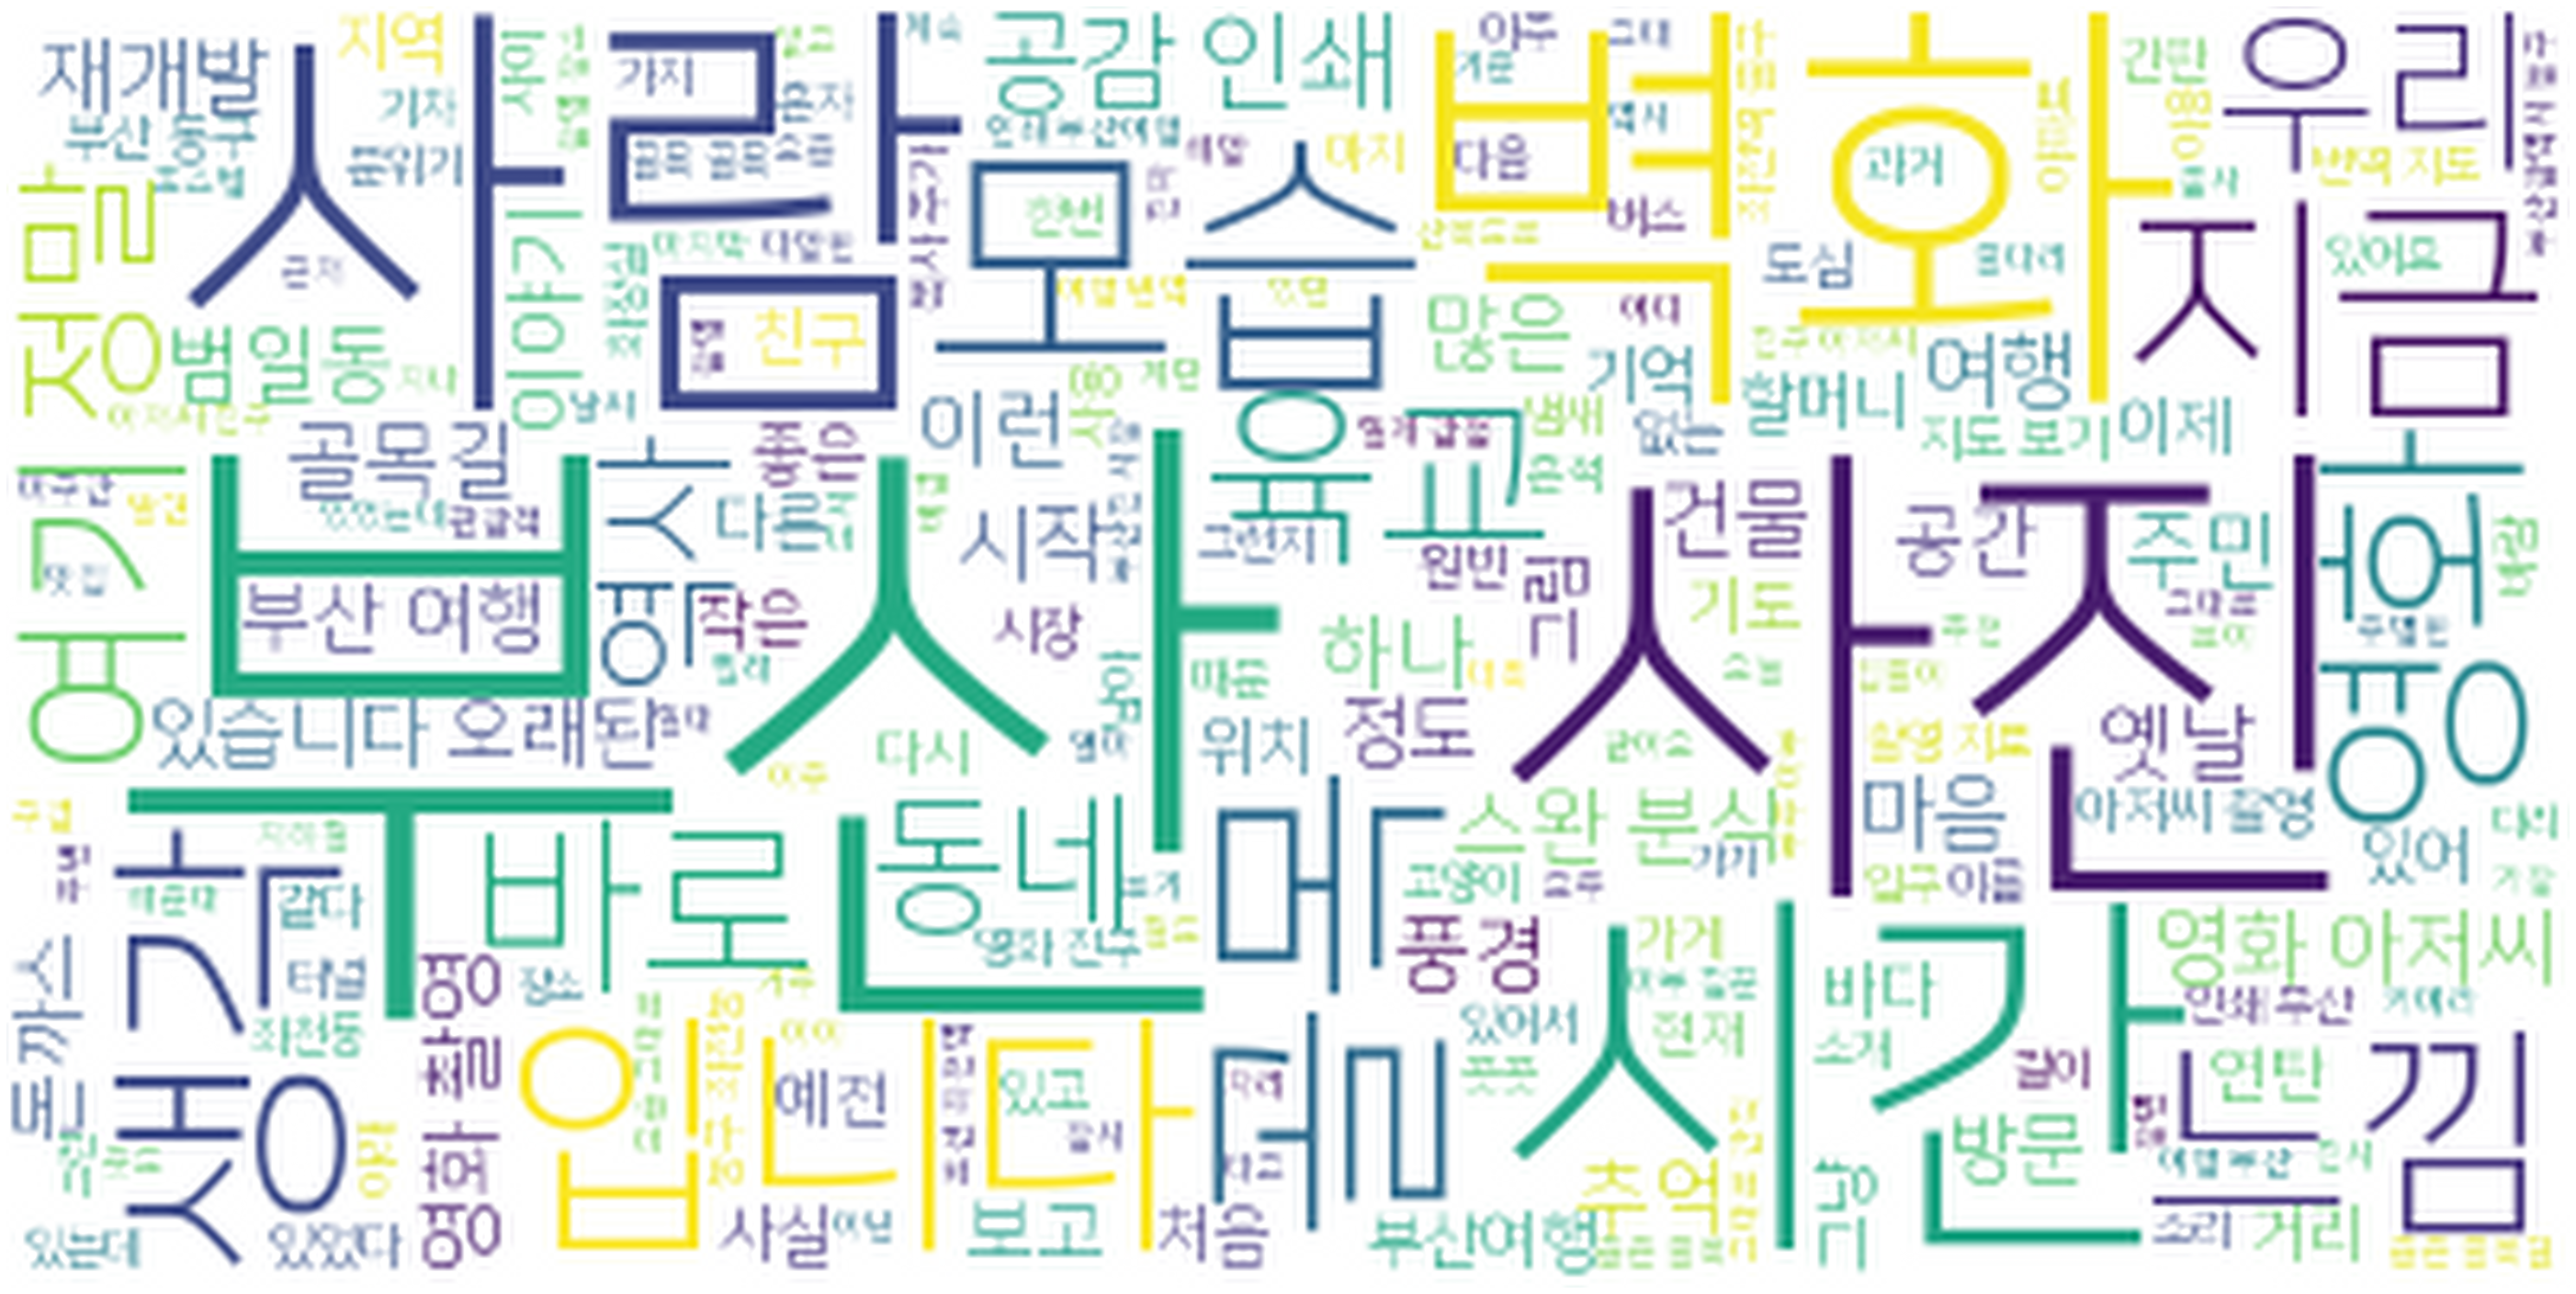

In [71]:

wordcloud = WordCloud(font_path="./NanumSquareL.ttf", 
                      background_color='white',
                        stopwords=stopwords
                     ).generate(" ".join(posts))
plt.figure(figsize=(50,50)) #이미지 사이즈 지정
plt.imshow(wordcloud, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off') #x y 축 숫자 제거
plt.show() 
# plt.savefig()

In [72]:
for i,v in sorted(Counter(all_terms).items(), key=lambda x:x[1], reverse=True):
    print(F"{i}: {v}")

부산: 580
영화: 309
골목: 223
사진: 219
사람: 214
촬영: 206
벽화: 206
아저씨: 204
여행: 203
모습: 184
시간: 183
친구: 166
입니다: 136
생각: 128
육교: 120
지금: 116
동구: 102
주민: 100
골목길: 100
인쇄: 97
느낌: 97
공감: 96
바로: 96
동네: 89
여기: 87
많은: 87
하나: 86
부산여행: 86
우리: 85
역사: 85
정말: 84
건물: 83
보기: 82
지도: 80
좌천동: 78
추억: 76
범일동: 75
풍경: 74
분식: 71
스완: 69
번역: 69
이런: 67
원빈: 67
그대로: 66
재개발: 66
시작: 64
좌천역: 63
시장: 61
바다: 61
마음: 61
출구: 60
돈까스: 60
좁은: 60
연탄: 58
방문: 57
거리: 57
지역: 57
아파트: 57
이야기: 56
옛날: 55
오래된: 55
흔적: 54
가게: 53
있습니다: 53
현재: 52
도심: 51
공간: 51
보고: 51
굴다리: 51
다시: 50
지하철: 50
정도: 49
이제: 48
기도: 48
전쟁: 48
좋은: 48
사이: 47
장소: 46
지로: 46
그림: 46
이용: 46
작은: 46
그냥: 46
다른: 45
할머니: 45
냄새: 45
예전: 44
기억: 44
간직: 44
시절: 44
위치: 44
있어: 44
때문: 44
처음: 43
사실: 43
곳곳: 43
과거: 43
사용: 42
화장실: 42
터널: 41
유명한: 41
마구간: 41
기차: 41
있고: 41
간판: 39
없는: 39
한번: 39
입구: 38
같다: 38
있었다: 38
형성: 37
아래: 37
자리: 37
버스: 37
타고: 36
도시: 36
피난민: 36
고양이: 36
마치: 35
있는데: 35
있어서: 34
일제강점기: 34
가장: 34
당시: 34
전당포: 34
아주: 33
그런지: 33
일제: 33
장면: 33
문화: 33
가지: 32
이후: 32
주변: 32
혼자: 32
소개: 32
바람: 

의심: 2
분명: 2
놀이터: 2
높아: 2
몇개: 2
가깝다: 2
있었는지: 2
짐작: 2
패트병: 2
위함: 2
표시: 2
없다면: 2
번길: 2
든든하게: 2
사나이: 2
스러운: 2
용돈: 2
천만: 2
진지하다: 2
세탁소: 2
신식: 2
시끄럽게: 2
존중: 2
가보: 2
있었을텐데: 2
바리: 2
청수: 2
뷰티살롱: 2
마켙: 2
국민학교: 2
졸업: 2
아니니까: 2
대여: 2
공중전화: 2
아트: 2
아를르: 2
테라스: 2
자화상: 2
감동: 2
눈물: 2
나오니: 2
모나리자: 2
자칫: 2
억지로: 2
개구쟁이: 2
고냥이: 2
재미나: 2
들국화: 2
반지: 2
무서워서: 2
흡입: 2
까만: 2
뭘위: 2
도시락: 2
껍질: 2
바싹: 2
불쑥: 2
방도: 2
정세: 2
점차: 2
남북: 2
관계: 2
경원선: 2
양쪽: 2
원만한: 2
시민: 2
크루즈: 2
없기에: 2
정박: 2
부족한: 2
좁아서: 2
많았기에: 2
신선: 2
포항: 2
맛있고: 2
동태: 2
커피숍: 2
아메리카노: 2
아쉬운: 2
기약: 2
고마운: 2
상징: 2
부서: 2
휴가: 2
대한민국: 2
저런: 2
각광: 2
젊은이: 2
유오성: 2
교복: 2
뒤안길: 2
완공: 2
년전: 2
충격: 2
선명하다: 2
추격: 2
가난한: 2
우울한: 2
색상: 2
광고: 2
이따: 2
좋아해서: 2
산다: 2
성인: 2
세로: 2
휴일: 2
좋았는데: 2
는걸: 2
단연: 2
태양: 2
궁금해진다: 2
소주: 2
채소: 2
뒤쪽: 2
무단: 2
투기: 2
과연: 2
도로로: 2
북서쪽: 2
남서쪽: 2
남쪽: 2
동쪽: 2
같았어요: 2
공짜: 2
피난: 2
옳은: 2
감천동: 2
색다른: 2
중고: 2
버스정류장: 2
호국: 2
보훈: 2
취소: 2
길지: 2
아쉽게도: 2
일로: 2
달달: 2
즈음: 2
기대: 2
아미동: 2
영토: 2
중요한: 2
종도: 2
급하게: 2
안뇽: 2
다양하게: 2
대박: 2
규모: 2
라인: 2
딱지: 2
가다가: 2
린다: 

오래되었다고: 1
무조건: 1
효과: 1
대단하다는: 1
드니: 1
없이도: 1
아기자기함에: 1
친히: 1
옥수: 1
무얼: 1
궁금하네: 1
바빠던: 1
반복: 1
두서: 1
나열하도록: 1
보충: 1
좋아할거라며: 1
앞장: 1
맑고: 1
예뻤구나: 1
뒷길: 1
반전: 1
길쭉한: 1
독특하고: 1
시리기까지: 1
행복한데: 1
만족스러웠다: 1
얼씨구: 1
복병: 1
있었으니: 1
벌벌: 1
진땀: 1
군산: 1
작업실: 1
있는만큼: 1
갈수록: 1
상당한데: 1
엄두: 1
귀엽다: 1
만점: 1
칠해놓은: 1
기대하는: 1
막연한: 1
큼지막한: 1
기본: 1
더하는데: 1
중점: 1
우드: 1
체어: 1
괴롭더라도: 1
대관람차: 1
베리: 1
요거트: 1
라떼: 1
예쁘고: 1
매트: 1
스러워: 1
없다는: 1
연결하여: 1
식겁하며: 1
놀래긴: 1
이렇게나마: 1
배터리: 1
얼추: 1
크리스마스: 1
트리: 1
유명한줄은: 1
완당: 1
불끈: 1
조바심: 1
급한: 1
척척: 1
박사: 1
설레임: 1
가득하다: 1
조용하니: 1
좋단다: 1
역임: 1
애초: 1
무허가: 1
관공서: 1
많거나: 1
컨텐츠: 1
있다거나: 1
자그만한: 1
메뉴인: 1
두툼: 1
맛있는거: 1
독특합니다: 1
무산: 1
전신: 1
의견: 1
환영: 1
알도: 1
기장: 1
기독교: 1
유명하다하여: 1
건어물: 1
수산물: 1
소매: 1
직판: 1
급해서: 1
간곳: 1
주전부리: 1
많음: 1
오징어: 1
군것질: 1
기념품: 1
이디야: 1
십이지: 1
석상: 1
기원: 1
소중하듯: 1
남도: 1
사찰: 1
유명함: 1
맑아서: 1
신비한: 1
약수터: 1
행운: 1
연못: 1
골인: 1
스러와: 1
짝짝: 1
절실: 1
좋게도: 1
제트: 1
스키: 1
인방: 1
물쇼: 1
있었구: 1
시원해: 1
보임: 1
황금돼지: 1
기념샷: 1
참배: 1
퇴장: 1
실컷: 1
이나영: 1
부럽: 1
시시한: 1
범죄예방: 1
아티스트: 1
안전한: 1


설렘과: 1
들뜸으로: 1
늦잠: 1
이런다: 1
넉넉하겠다: 1
같았으면: 1
성은: 1
구포역: 1
부흥: 1
많을수록: 1
그렇지: 1
저고리: 1
아부지: 1
완벽하게: 1
잘생길: 1
반할: 1
예쁘다: 1
이런거: 1
유머러스하고: 1
친절하신: 1
쭈뼛거림과: 1
성큼성큼: 1
당황: 1
스럽: 1
유럽: 1
절대로: 1
아기: 1
쉬웠지만: 1
예쁘더라: 1
필요했던: 1
있었다고: 1
대단하게: 1
얘길: 1
신기하구먼: 1
단말: 1
신격화: 1
도나: 1
전화기: 1
아날로그: 1
글세: 1
삭월세: 1
마켇: 1
만요: 1
빈센트: 1
포룸: 1
광장: 1
일밤: 1
밤하늘: 1
피카소: 1
페브: 1
리트: 1
아니었고: 1
단순: 1
솜씨: 1
호랑이: 1
붕대: 1
직히: 1
흐느적흐느적: 1
그러셨다: 1
조용한지: 1
천차만별: 1
이랬구나: 1
유명했다: 1
쓸쓸하고: 1
자연스럽고: 1
한적하고: 1
쓸쓸함이: 1
조용했던: 1
이의: 1
상품화: 1
야했던: 1
모이: 1
비참해: 1
당당함이: 1
무우: 1
옥수수: 1
허무함을: 1
쿠팡: 1
있을소냐: 1
네버: 1
지갑: 1
따끈따끈한: 1
꿀물: 1
자몽: 1
저렴했지만: 1
야했기에: 1
결제: 1
글쎄: 1
같아서는: 1
로맨틱코미디: 1
혹스: 1
그럴까: 1
답답할까: 1
좋아하면: 1
부끄러움: 1
어마: 1
주입: 1
자존심: 1
에피소드: 1
좋아하며: 1
왕자: 1
무뚝뚝하던: 1
하늘나라: 1
엉엉: 1
전하: 1
아니었을까: 1
연기력: 1
생생함이: 1
자리는: 1
앞줄: 1
몸짓: 1
자유로운: 1
적절한: 1
애드리브: 1
오바이트: 1
교감: 1
상쾌했다: 1
정작: 1
색도: 1
홍콩: 1
결론: 1
리까: 1
경성대: 1
있었으면: 1
좋다면: 1
지겹지도: 1
튜브: 1
자식: 1
무리: 1
버느: 1
반일: 1
불평: 1
그랬을테지만: 1
그러지: 1
필요해: 1
보태: 1
좋으려고: 1
좋아하라고: 1
그래야지: 1
아쉬워하지말고: 